In [ ]:
# !pip install --upgrade git+https://github.com/tum-pbs/PhiFlow@2.2-develop

In [1]:
import os, sys, logging, argparse, pickle, glob, random, distutils.dir_util, urllib.request

# fname_train = 'sol-karman-2d-train.pickle'
# if not os.path.isfile(fname_train):
#   print("Downloading training data (73MB), this can take a moment the first time...")
#   urllib.request.urlretrieve("https://physicsbaseddeeplearning.org/data/"+fname_train, fname_train)

# with open(fname_train, 'rb') as f: data_preloaded = pickle.load(f)
# print("Loaded data, {} training sims".format(len(data_preloaded)) )

fname_train = 'karman_train_1.pickle'

with open(fname_train, 'rb') as f: 
  data_preloaded = pickle.load(f)
  
print("Loaded data, {} training sims".format(len(data_preloaded)))


Loaded data, 6 training sims


In [2]:
from phi.tf.flow import *
import tensorflow as tf
from tensorflow import keras

random.seed(42) 
np.random.seed(42)
tf.random.set_seed(42)

phi.__version__

'2.2.0'

In [3]:
def network_small(inputs_dict):
    l_input = keras.layers.Input(**inputs_dict)
    block_0 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_input)
    block_0 = keras.layers.LeakyReLU()(block_0)

    l_conv1 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_0)
    l_conv1 = keras.layers.LeakyReLU()(l_conv1)
    l_conv2 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv1)
    block_1 = keras.layers.LeakyReLU()(l_conv2)

    l_output = keras.layers.Conv2D(filters=2,  kernel_size=5, padding='same')(block_1) # u, v
    return keras.models.Model(inputs=l_input, outputs=l_output, name='small_Network')


In [4]:
def network_medium(inputs_dict):
    l_input = keras.layers.Input(**inputs_dict)
    block_0 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_input)
    block_0 = keras.layers.LeakyReLU()(block_0)

    l_conv1 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_0)
    l_conv1 = keras.layers.LeakyReLU()(l_conv1)
    l_conv2 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv1)
    l_skip1 = keras.layers.add([block_0, l_conv2])
    block_1 = keras.layers.LeakyReLU()(l_skip1)

    l_conv3 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_1)
    l_conv3 = keras.layers.LeakyReLU()(l_conv3)
    l_conv4 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv3)
    l_skip2 = keras.layers.add([block_1, l_conv4])
    block_2 = keras.layers.LeakyReLU()(l_skip2)

    l_conv5 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_2)
    l_conv5 = keras.layers.LeakyReLU()(l_conv5)
    l_conv6 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv5)
    l_skip3 = keras.layers.add([block_2, l_conv6])
    block_3 = keras.layers.LeakyReLU()(l_skip3)

    l_conv7 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_3)
    l_conv7 = keras.layers.LeakyReLU()(l_conv7)
    l_conv8 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv7)
    l_skip4 = keras.layers.add([block_3, l_conv8])
    block_4 = keras.layers.LeakyReLU()(l_skip4)

    l_conv9 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_4)
    l_conv9 = keras.layers.LeakyReLU()(l_conv9)
    l_convA = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv9)
    l_skip5 = keras.layers.add([block_4, l_convA])
    block_5 = keras.layers.LeakyReLU()(l_skip5)

    l_output = keras.layers.Conv2D(filters=2,  kernel_size=5, padding='same')(block_5)
    return keras.models.Model(inputs=l_input, outputs=l_output, name='mediuml_Network')

In [5]:

def to_keras(dens_vel_grid_array, ext_const_channel):
    # align the sides the staggered velocity grid making its size the same as the centered grid
    return math.stack(
        [
            math.pad( dens_vel_grid_array[1].vector['x'].values, \
                {'x':(0,1)} , math.extrapolation.ZERO),               # u
            dens_vel_grid_array[1].vector['y'].y[:-1].values,         # v
            math.ones(dens_vel_grid_array[0].shape)*ext_const_channel # Re
        ],
        math.channel('channels')
    )

def to_phiflow(tf_tensor, domain):
    # print(tf_tensor.shape)
    a =  StaggeredGrid(
        math.stack(
            [
                math.tensor(tf.pad(tf_tensor[..., 1], \
                    [(0,0), (0,1), (0,0)]), math.batch('batch'), math.spatial('y, x')), # v
                math.tensor( tf_tensor[...,:-1, 0], \
                    math.batch('batch'), math.spatial('y, x')), # u 
            ], math.channel(vector='y, x')
        ), **domain
    )
    # print('%%%%% a shape %%%%%%%')
    # print("y vctor: ", a.vector['y'])
    # print("x vector: ", a.vector['x'])
    # print("Grid: ", a)
    # print('%%%%% a shape %%%%%%%')
    return a


In [6]:
class Dataset():
    def __init__(self, data_preloaded, num_frames, num_sims=None, batch_size=1, is_testset=False):
        self.epoch         = None
        self.epochIdx      = 0
        self.batch         = None
        self.batchIdx      = 0
        self.step          = None
        self.stepIdx       = 0

        self.dataPreloaded = data_preloaded
        self.batchSize     = batch_size

        self.numSims       = num_sims
        self.numBatches    = num_sims//batch_size
        self.numFrames     = num_frames
        self.numSteps      = num_frames
        
        # initialize directory keys (using naming scheme from SoL codebase)
        # constant additional per-sim channel: Reynolds numbers from data generation
        # hard coded for training and test data here
        if not is_testset:
            self.dataSims = ['karman-fdt-hires-set_1/sim_%06d'%i for i in range(num_sims) ]
            ReNrs = [160000.0, 320000.0, 640000.0,  1280000.0,  2560000.0,  5120000.0]
            self.extConstChannelPerSim = { self.dataSims[i]:[ReNrs[i]] for i in range(num_sims) }
        else:
            self.dataSims = ['karman-fdt-hires-testset_1/sim_%06d'%i for i in range(num_sims) ]
            ReNrs = [120000.0, 480000.0, 1920000.0, 7680000.0] 
            self.extConstChannelPerSim = { self.dataSims[i]:[ReNrs[i]] for i in range(num_sims) }

        self.dataFrames = [ np.arange(num_frames) for _ in self.dataSims ]  

        # debugging example, check shape of a single marker density field:
        #print(format(self.dataPreloaded[self.dataSims[0]][0][0].shape )) 
        
        # the data has the following shape ['sim', frame, field (dens/vel)] where each field is [batch-size, y-size, x-size, channels]
        self.resolution = self.dataPreloaded[self.dataSims[0]][0][0].shape[1:3]  

        # compute data statistics for normalization
        self.dataStats = {
            'std': (
                np.std(np.concatenate([np.absolute(self.dataPreloaded[asim][i][0].reshape(-1)) \
                    for asim in self.dataSims for i in range(num_frames)], axis=-1)), # density
                np.std(np.concatenate([np.absolute(self.dataPreloaded[asim][i][1].reshape(-1)) \
                    for asim in self.dataSims for i in range(num_frames)], axis=-1)), # x-velocity
                np.std(np.concatenate([np.absolute(self.dataPreloaded[asim][i][2].reshape(-1)) \
                    for asim in self.dataSims for i in range(num_frames)], axis=-1)), # y-velocity
            )
        }
        self.dataStats.update({
            'ext.std': [ np.std([np.absolute(self.extConstChannelPerSim[asim][0]) for asim in self.dataSims]) ] # Reynolds Nr
        })

        
        if not is_testset:
            print("Data stats: "+format(self.dataStats))


    # re-shuffle data for next epoch
    def newEpoch(self, exclude_tail=0, shuffle_data=True):
        self.numSteps = self.numFrames - exclude_tail
        simSteps = [ (asim, self.dataFrames[i][0:(len(self.dataFrames[i])-exclude_tail)]) for i,asim in enumerate(self.dataSims) ]
        sim_step_pair = []
        for i,_ in enumerate(simSteps):
            sim_step_pair += [ (i, astep) for astep in simSteps[i][1] ]  # (sim_idx, step) ...

        if shuffle_data: random.shuffle(sim_step_pair)
        self.epoch = [ list(sim_step_pair[i*self.numSteps:(i+1)*self.numSteps]) for i in range(self.batchSize*self.numBatches) ]
        self.epochIdx += 1
        self.batchIdx = 0
        self.stepIdx = 0

    def nextBatch(self):  
        self.batchIdx += self.batchSize
        self.stepIdx = 0

    def nextStep(self):
        self.stepIdx += 1


In [7]:
# for class Dataset():
def getData(self, consecutive_frames):
    d_hi = [
        np.concatenate([
            self.dataPreloaded[
                self.dataSims[self.epoch[self.batchIdx+i][self.stepIdx][0]] # sim_key
            ][
                self.epoch[self.batchIdx+i][self.stepIdx][1]+j # frames
            ][0]
            for i in range(self.batchSize)
        ], axis=0) for j in range(consecutive_frames+1)
    ]
    u_hi = [
        np.concatenate([
            self.dataPreloaded[
                self.dataSims[self.epoch[self.batchIdx+i][self.stepIdx][0]] # sim_key
            ][
                self.epoch[self.batchIdx+i][self.stepIdx][1]+j # frames
            ][1]
            for i in range(self.batchSize)
        ], axis=0) for j in range(consecutive_frames+1)
    ]
    v_hi = [
        np.concatenate([
            self.dataPreloaded[
                self.dataSims[self.epoch[self.batchIdx+i][self.stepIdx][0]] # sim_key
            ][
                self.epoch[self.batchIdx+i][self.stepIdx][1]+j # frames
            ][2]
            for i in range(self.batchSize)
        ], axis=0) for j in range(consecutive_frames+1)
    ]
    ext = [
        self.extConstChannelPerSim[
            self.dataSims[self.epoch[self.batchIdx+i][self.stepIdx][0]]
        ][0] for i in range(self.batchSize)
    ]
    return [d_hi, u_hi, v_hi, ext]


In [8]:
nsims = 6
batch_size = 1
simsteps = 499

dataset = Dataset(data_preloaded=data_preloaded, \
                num_frames=simsteps, num_sims=nsims, \
                batch_size=batch_size )

Data stats: {'std': (2.0817313, 0.15967862, 0.4097484), 'ext.std': [1732512.6262166172]}


In [9]:
class KarmanFlow():
    def __init__(self, domain):
        # self.domain = domain

        self.vel_BcMask = StaggeredGrid(HardGeometryMask(Box['y, x', :5, :]), **domain)
        # print("=======vel_BcMask=======")
        # print(self.vel_BcMask.vector['y'])
        # print(self.vel_BcMask.vector['x'])
        # print("=======vel_BcMask=======")
        self.inflow = CenteredGrid(Box['y, x', 5:10, 25:75], **domain)  # scale with domain if necessary!
        # vis.plot(self.inflow)
        self.obstacles = [Obstacle(Sphere(y=50, x=50, radius=10))]

    # re = ReNum, res = Resolution
    def step(self, density_in, velocity_in, re, res, buoyancy_factor=1, dt=1.0):
        velocity = velocity_in
        density = density_in

        # viscosity
        velocity = phi.flow.diffuse.explicit(field=velocity, diffusivity=1.0/re*dt*res*(res/2), dt=dt)
        # print(velocity)
        
        # inflow boundary conditions
        velocity = velocity*(1.0 - self.vel_BcMask) + self.vel_BcMask * (buoyancy_factor, 0)

        # advection 
        density = advect.semi_lagrangian(density+self.inflow, velocity, dt=dt)
        velocity = advected_velocity = advect.semi_lagrangian(velocity, velocity, dt=dt)

        # mass conservation (pressure solve)
        pressure = None
        velocity, pressure = fluid.make_incompressible(velocity, self.obstacles)
        self.solve_info = { 'pressure': pressure, 'advected_velocity': advected_velocity }
        
        return [density, velocity]

In [10]:
# one of the most crucial! how many simulation 
# steps to look into the future while training
msteps = 4

# # this is the actual resolution in terms of cells
source_res = list(dataset.resolution)
print(source_res)
# # this is a virtual size, in terms of abstract units for the bounding 
# box of the domain (it's important for conversions or when 
# rescaling to physical units)
simulation_length = 100.

# for readability
# from phi.physics._boundaries import Domain, OPEN, STICKY as CLOSED

# simulation_length = 100.

# boundary_conditions = {
#     'y':(phi.physics._boundaries.OPEN,  phi.physics._boundaries.OPEN),
#     'x':(phi.physics._boundaries.STICKY,phi.physics._boundaries.STICKY)}

# domain = Domain(y=source_res[0], x=source_res[1],\
#     bounds=Box['y, x', 0:2*simulation_length, 0:simulation_length], boundaries=boundary_conditions)

# vis.plot(domain)

# domain = dict(x=source_res[1], y=source_res[0],\
#     bounds=Box['x, y', 0:simulation_length, 0:2*simulation_length])

domain = dict(y=source_res[0], x=source_res[1], \
            extrapolation=extrapolation.combine_sides(x=extrapolation.ZERO, \
            y=extrapolation.BOUNDARY), \
            bounds=Box['y, x', 0:2*simulation_length, 0:simulation_length])

# vel_BcMask = StaggeredGrid(HardGeometryMask(Box['x, y', :5, :]), \
#     extrapolation=extrapolation.ZERO, **domain)

# vis.plot(vel_BcMask)

simulator = KarmanFlow(domain=domain)

network = network_small(dict(shape=(source_res[0],source_res[1], 3)))
network.summary()

LR = 1e-4
EPOCHS = 15

opt = tf.keras.optimizers.Adam(learning_rate=LR) 

[64, 32]
Model: "small_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 32, 32)        2432      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 32, 32)        25632     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 32, 32)        25632     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64, 32, 

In [11]:
# domain = dict(x=64, y=64, \
#     bounds=Box['x, y', 0:100, 0:200])


# vel_BcMask = StaggeredGrid(HardGeometryMask(Box['x, y', :5, :]), \
#     extrapolation=extrapolation.ZERO, **domain)

# inflow = CenteredGrid(Box['x, y', 5:10, 25:75], \
#     extrapolation=extrapolation.BOUNDARY, **domain)


# vis.plot(inflow)

In [12]:
def training_step(dens_gt, vel_gt, Re, i_step):
    with tf.GradientTape() as tape:
        prediction, correction = [ [dens_gt[0],vel_gt[0]] ], [0] # predicted states with correction, inferred velocity corrections

        for i in range(msteps):
            # print("++++++++++++++++++++")
            # print("Before Loop")
            prediction += [
                simulator.step(
                    density_in=prediction[-1][0],
                    velocity_in=prediction[-1][1],
                    re=Re, res=source_res[0],
                )
            ]    # prediction: [[density1, velocity1], [density2, velocity2], ...]
            # print("++++++++++++++++++++")
            # print("Before Loop")
            model_input = to_keras(prediction[-1], Re)
            model_input /= math.tensor([dataset.dataStats['std'][1], \
                dataset.dataStats['std'][2], dataset.dataStats['ext.std'][0]], channel('channels')) # [u, v, Re]
            model_out = network(model_input.native(['batch', 'y', 'x', 'channels']), training=True)
            model_out *= [dataset.dataStats['std'][1], dataset.dataStats['std'][2]] # [u, v]
            correction += [ to_phiflow(model_out, domain) ]   # [velocity_correction1, velocity_correction2, ...]

            prediction[-1][1] = prediction[-1][1] + correction[-1]
            #prediction[-1][1] = correction[-1]

        # evaluate loss
        loss_steps_x = [
            tf.nn.l2_loss(
                (
                    vel_gt[i].vector['x'].values.native(('batch', 'y', 'x'))
                    - prediction[i][1].vector['x'].values.native(('batch', 'y', 'x'))
                )/dataset.dataStats['std'][1]
            )
            for i in range(1, msteps+1)
        ]
        loss_steps_x_sum = tf.math.reduce_sum(loss_steps_x)

        loss_steps_y = [
            tf.nn.l2_loss(
                (
                    vel_gt[i].vector['y'].values.native(('batch', 'y', 'x'))
                    - prediction[i][1].vector['y'].values.native(('batch', 'y', 'x'))
                )/dataset.dataStats['std'][2]
            )
            for i in range(1, msteps+1)
        ]
        loss_steps_y_sum = tf.math.reduce_sum(loss_steps_y)

        loss = (loss_steps_x_sum + loss_steps_y_sum)/msteps

        gradients = tape.gradient(loss, network.trainable_variables)
        opt.apply_gradients(zip(gradients, network.trainable_variables))

        return math.tensor(loss)    


In [13]:

training_step_jit = math.jit_compile(training_step)

In [14]:
# LR = 1e-4
# EPOCHS = 15

# opt = tf.keras.optimizers.Adam(learning_rate=LR) 

# optional, load existing network...
# set to epoch nr. to load existing network from there
resume = 0
if resume>0: 
    ld_network = keras.models.load_model('./h5/nn_epoch{:04d}.h5'.format(resume)) 
    #ld_network = keras.models.load_model('./nn_final.h5') # or the last one
    network.set_weights(ld_network.get_weights())
    

In [15]:
dataset.newEpoch(exclude_tail=msteps)
batch = getData(dataset, consecutive_frames=msteps)
vel_gt = [   # [velocity0:StaggeredGrid, velocity1, ...]
    StaggeredGrid(
        math.stack(
            [
                math.tensor(batch[2][k], math.batch('batch'), math.spatial('y, x')),
                math.tensor(batch[1][k], math.batch('batch'), math.spatial('y, x')),
            ],  math.channel(vector='y, x')
        ), **domain
    ) for k in range(msteps+1)
]

In [16]:
steps = 0
for j in range(EPOCHS):  # training
    dataset.newEpoch(exclude_tail=msteps)
    if j<resume:
        print('resume: skipping {} epoch'.format(j+1))
        steps += dataset.numSteps*dataset.numBatches
        continue

    for ib in range(dataset.numBatches):   
        for i in range(dataset.numSteps): 
            # resolution2x = dict(y=64, x=32)
            # domain2x = dict(**resolution2x, bounds=Box['y, x', 0:200, 0:100])
            # batch: [[dens0, dens1, ...], [x-velo0, x-velo1, ...], [y-velo0, y-velo1, ...], [ReynoldsNr(s)]]            
            batch = getData(dataset, consecutive_frames=msteps)
            
            dens_gt = [   # [density0:CenteredGrid, density1, ...]
                CenteredGrid(
                    math.tensor(batch[0][k], math.batch('batch'), math.spatial('y, x')),
                    **domain
                ) for k in range(msteps+1)
            ]  

            # print('dens_gt\n')
            # print(dens_gt[-1])
            # print(dens_gt[-1].shape)
            # # vis.plot(dens_gt[-1])
            # break

            vel_gt = [   # [velocity0:StaggeredGrid, velocity1, ...]
                StaggeredGrid(
                    math.stack(
                        [
                            math.tensor(batch[2][k], math.batch('batch'), math.spatial('y, x')),
                            math.tensor(batch[1][k], math.batch('batch'), math.spatial('y, x')),
                        ],  math.channel(vector='y, x')
                    ), **domain
                ) for k in range(msteps+1)
            ]
            # print(vel_gt[-1])
            # print('velo passed\n')
            # print(vel_gt[-1].vector['y'])
            # print('\n')
            # print(vel_gt[-1].vector['x'])
            # print('\n')
            # print(vel_gt[-1].extrapolation)
            # # vis.plot(vel_gt[-1])
            # break
            
            re_nr = math.tensor(batch[3], math.batch('batch'))

            loss = training_step_jit(dens_gt, vel_gt, re_nr, math.tensor(steps)) 
            
            steps += 1
            if (j==0 and ib==0 and i<3) or (j==0 and ib==0 and i%128==0) or (j>0 and ib==0 and i==400): # reduce output 
              print('epoch {:03d}/{:03d}, batch {:03d}/{:03d}, step {:04d}/{:04d}: loss={}'.format( j+1, EPOCHS, ib+1, dataset.numBatches, i+1, dataset.numSteps, loss ))
            
            dataset.nextStep()

        dataset.nextBatch()

    if j%10==9: network.save('./h5/nn_epoch{:04d}.h5'.format(j+1))

# all done! save final version
network.save('./h5/nn_final.h5'); print("Training done, saved NN")


epoch 001/015, batch 001/006, step 0001/0495: loss=924.3286
epoch 001/015, batch 001/006, step 0002/0495: loss=284.03296
epoch 001/015, batch 001/006, step 0003/0495: loss=235.07043
epoch 001/015, batch 001/006, step 0129/0495: loss=22.787868
epoch 001/015, batch 001/006, step 0257/0495: loss=14.229164
epoch 001/015, batch 001/006, step 0385/0495: loss=5.9816294
epoch 002/015, batch 001/006, step 0401/0495: loss=1.0886228
epoch 003/015, batch 001/006, step 0401/0495: loss=0.25794137
epoch 004/015, batch 001/006, step 0401/0495: loss=0.11117705
epoch 005/015, batch 001/006, step 0401/0495: loss=0.144894
epoch 006/015, batch 001/006, step 0401/0495: loss=0.07106807
epoch 007/015, batch 001/006, step 0401/0495: loss=0.034215324
epoch 008/015, batch 001/006, step 0401/0495: loss=0.08533312
epoch 009/015, batch 001/006, step 0401/0495: loss=0.062685855
epoch 010/015, batch 001/006, step 0401/0495: loss=0.013223042
epoch 011/015, batch 001/006, step 0401/0495: loss=0.05102799
epoch 012/015, 

In [17]:
network.save('./h5/nn_final.h5'); print("Training done, saved NN")

Training done, saved NN


In [18]:
fname_test = 'karman_test_1.pickle'
# if not os.path.isfile(fname_test):
#   print("Downloading test data (38MB), this can take a moment the first time...")
#   urllib.request.urlretrieve("https://physicsbaseddeeplearning.org/data/"+fname_test, fname_test)

with open(fname_test, 'rb') as f: 
  data_test_preloaded = pickle.load(f)
print("Loaded test data, {} training sims".format(len(data_test_preloaded)) )

Loaded test data, 4 training sims


In [20]:
dataset_test = Dataset( data_preloaded=data_test_preloaded, is_testset=True, num_frames=simsteps, num_sims=4, batch_size=4 )

# we only need 1 batch with t=0 states to initialize the test simulations with
dataset_test.newEpoch(shuffle_data=False)
batch = getData(dataset_test, consecutive_frames=1) 

re_nr_test = math.tensor(batch[3], math.batch('batch')) # Reynolds numbers
print("Reynolds numbers in test data set: "+format(re_nr_test))

Reynolds numbers in test data set: (120000.000, 480000.000, 1920000.000, 7680000.000) along batchᵇ


In [21]:
source_dens_final = math.tensor( batch[0][-1], math.batch('batch'), math.spatial('y, x'))

source_vel_final = StaggeredGrid(phi.math.stack(
    [
    math.tensor(batch[2][-1], math.batch('batch'),math.spatial('y, x')),
    math.tensor(batch[1][-1], math.batch('batch'),math.spatial('y, x'))
    ], math.channel(vector='y, x')
  ), **domain
)

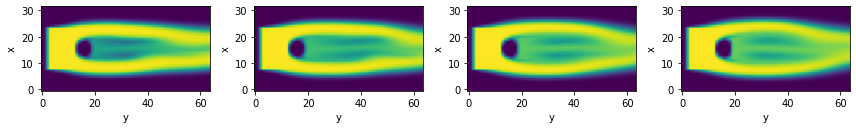

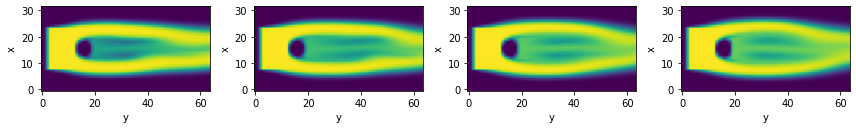

In [22]:
vis.plot(source_dens_final, show_color_bar= False)

In [23]:
source_dens_initial = math.tensor( batch[0][0], math.batch('batch'), math.spatial('y, x'))

source_vel_initial = StaggeredGrid(phi.math.stack(
    [
    math.tensor(batch[2][0], math.batch('batch'),math.spatial('y, x')),
    math.tensor(batch[1][0], math.batch('batch'),math.spatial('y, x'))
    ], math.channel(vector='y, x')
  ), **domain
)

In [24]:
source_dens_test, source_vel_test = source_dens_initial, source_vel_initial
steps_source = [[source_dens_test, source_vel_test]]

# note - math.jit_compile() not useful for numpy solve... hence not necessary
for i in range(simsteps):
    [source_dens_test,source_vel_test] = simulator.step(
        density_in=source_dens_test,
        velocity_in=source_vel_test,
        re=re_nr_test,
        res=source_res[1],
    )
    steps_source.append( [source_dens_test,source_vel_test] )

print("Source simulation steps "+format(len(steps_source)))

Source simulation steps 500


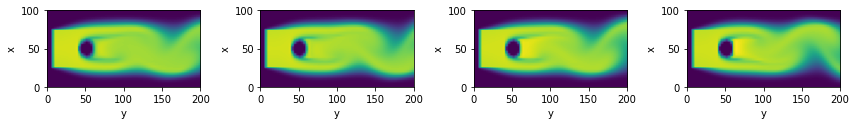

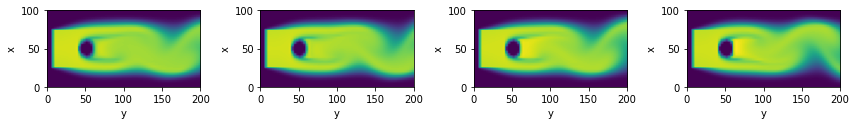

In [25]:
vis.plot(steps_source[-1][0], show_color_bar= False)

In [26]:
source_dens_test, source_vel_test = source_dens_initial, source_vel_initial
steps_hybrid = [[source_dens_test, source_vel_test]]
        
for i in range(simsteps):
    [source_dens_test,source_vel_test] = simulator.step(
        density_in=source_dens_test,
        velocity_in=source_vel_test,
        re=math.tensor(re_nr_test),
        res=source_res[1],
    )
    model_input = to_keras([source_dens_test,source_vel_test], re_nr_test )
    model_input /= math.tensor([dataset.dataStats['std'][1], dataset.dataStats['std'][2], dataset.dataStats['ext.std'][0]], channel('channels')) # [u, v, Re]
    model_out = network(model_input.native(['batch', 'y', 'x', 'channels']), training=False)
    model_out *= [dataset.dataStats['std'][1], dataset.dataStats['std'][2]] # [u, v]
    correction =  to_phiflow(model_out, domain) 
    source_vel_test = source_vel_test+correction

    steps_hybrid.append( [source_dens_test, source_vel_test] )
    
print("Steps with hybrid solver "+format(len(steps_hybrid)))

Steps with hybrid solver 500


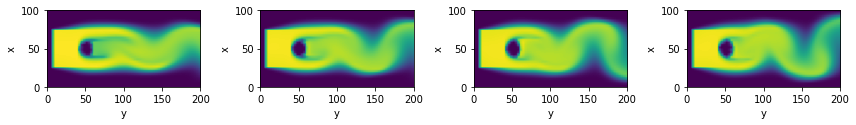

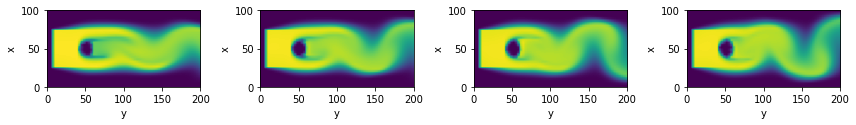

In [27]:
vis.plot(steps_hybrid[-1][0], show_color_bar= False)

MAE for source: 0.2706153988838196 , and hybrid: 0.052982818335294724


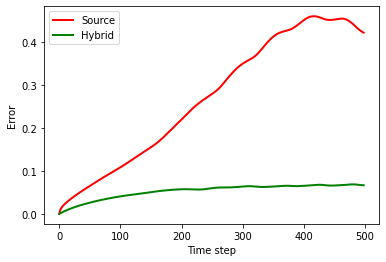

In [32]:
import pylab
b = 0 # batch index for the following comparisons

errors_source, errors_pred = [], []
for index in range(simsteps):
  vx_ref = dataset_test.dataPreloaded[ dataset_test.dataSims[b] ][ index ][1][0,...]
  vy_ref = dataset_test.dataPreloaded[ dataset_test.dataSims[b] ][ index ][2][0,...]
  vxs = vx_ref - steps_source[index][1].values.vector[1].numpy('batch,y,x')[b,...]
  vxh = vx_ref - steps_hybrid[index][1].values.vector[1].numpy('batch,y,x')[b,...]
  vys = vy_ref - steps_source[index][1].values.vector[0].numpy('batch,y,x')[b,...] 
  vyh = vy_ref - steps_hybrid[index][1].values.vector[0].numpy('batch,y,x')[b,...] 
  errors_source.append(np.mean(np.abs(vxs)) + np.mean(np.abs(vys))) 
  errors_pred.append(np.mean(np.abs(vxh)) + np.mean(np.abs(vyh)))

fig = pylab.figure().gca()
pltx = np.linspace(0,simsteps-1, simsteps)
fig.plot(pltx, errors_source, lw=2, color='red', label='Source')  
fig.plot(pltx, errors_pred,   lw=2, color='green', label='Hybrid')
pylab.xlabel('Time step'); pylab.ylabel('Error'); fig.legend()

print("MAE for source: "+format(np.mean(errors_source)) +" , and hybrid: "+format(np.mean(errors_pred)) )

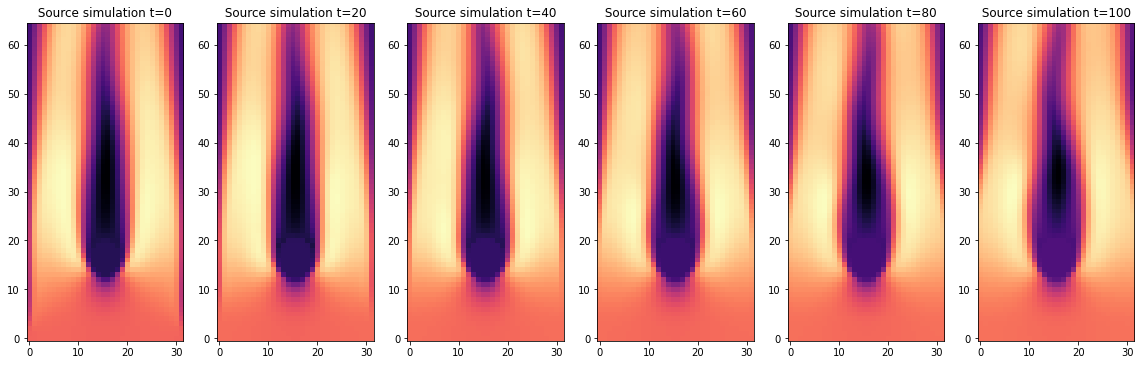

In [29]:
c = 0          # channel selector, x=1 or y=0 
interval = 20  # time interval

fig, axes = pylab.subplots(1, 6, figsize=(16, 5))    
for i in range(0,6):
  v = steps_source[i*interval][1].values.vector[c].numpy('batch,y,x')[b,...]
  axes[i].imshow( v , origin='lower', cmap='magma')
  axes[i].set_title(f" Source simulation t={i*interval} ")

pylab.tight_layout()

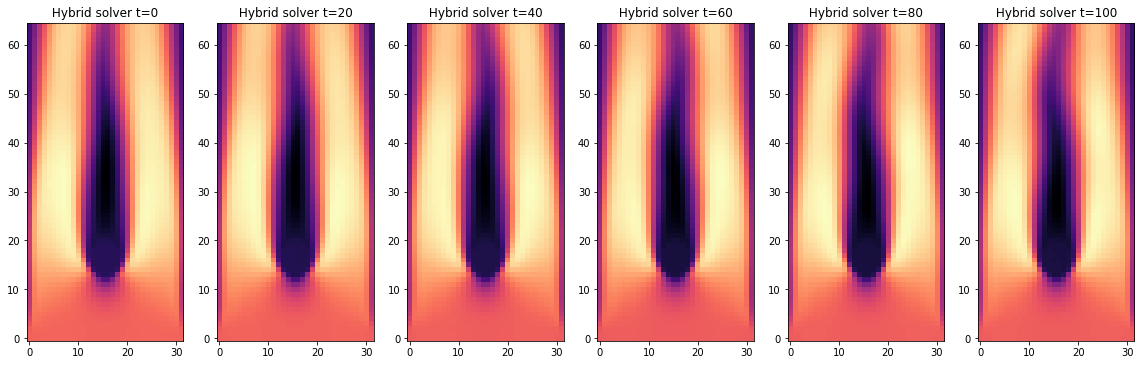

In [30]:
fig, axes = pylab.subplots(1, 6, figsize=(16, 5))
for i in range(0,6):
  v = steps_hybrid[i*interval][1].values.vector[c].numpy('batch,y,x')[b,...]
  axes[i].imshow( v , origin='lower', cmap='magma')
  axes[i].set_title(f" Hybrid solver t={i*interval} ")
pylab.tight_layout()

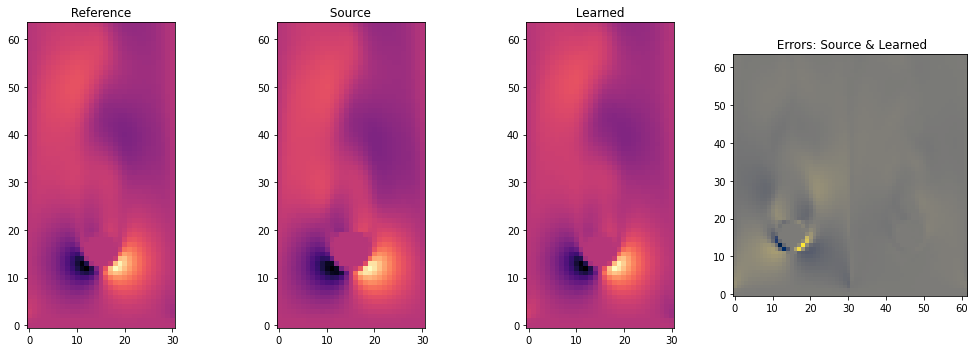

In [31]:
index = 50 # time step index
vx_ref = dataset_test.dataPreloaded[ dataset_test.dataSims[b] ][ index ][1][0,...]
vx_src = steps_source[index][1].values.vector[1].numpy('batch,y,x')[b,...]
vx_hyb = steps_hybrid[index][1].values.vector[1].numpy('batch,y,x')[b,...]

fig, axes = pylab.subplots(1, 4, figsize=(14, 5))

axes[0].imshow( vx_ref , origin='lower', cmap='magma')
axes[0].set_title(f" Reference ")

axes[1].imshow( vx_src , origin='lower', cmap='magma')
axes[1].set_title(f" Source ")

axes[2].imshow( vx_hyb , origin='lower', cmap='magma')
axes[2].set_title(f" Learned ")

# show error side by side
err_source = vx_ref - vx_src 
err_hybrid = vx_ref - vx_hyb 
v = np.concatenate([err_source,err_hybrid], axis=1)
axes[3].imshow( v , origin='lower', cmap='cividis')
axes[3].set_title(f" Errors: Source & Learned")

pylab.tight_layout()